# from PIL import Image
import torchvision.transforms as transforms
from diffusers import StableDiffusionInpaintPipeline
import torch
from pathlib import Path
import os

In [1]:
!pip install transformers diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 49.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from PIL import Image
import torchvision.transforms as transforms
from diffusers import StableDiffusionInpaintPipeline
import torch
from pathlib import Path
import os

In [3]:
ref_image_path = Path('./training_data/phil/phil_head.png')
ref_image = Image.open(ref_image_path)

In [46]:

train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Pad(200),
    transforms.Resize(512)
])

transformed_image = train_transform(ref_image)


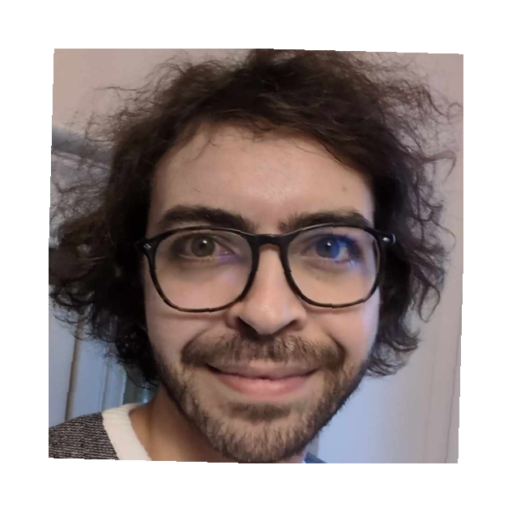

In [5]:
transformed_image

In [40]:
def compute_transparency_mask(image):
    """Compute transparency mask for an image.
    Args:
        image (PIL.Image): Input image.
    Returns:
        PIL.Image: Inverted Transparency mask.
    """
    alpha = image.getchannel('A')

    # Create a new image with the same size as the alpha channel and a default color of white (255)
    mask = Image.new('L', image.size, color=255)
    
    # Paste the inverted alpha channel into the mask image
    # Inverted here means we subtract the alpha values from 255 (white)
    # So where the alpha is 255 (fully opaque), the mask will be 0 (black)
    # And where the alpha is 0 (fully transparent), the mask will be 255 (white)
    inverted_alpha = Image.eval(alpha, lambda a: 255 if a == 0 else 0)
    mask.paste(inverted_alpha, (0, 0))

        
    return mask

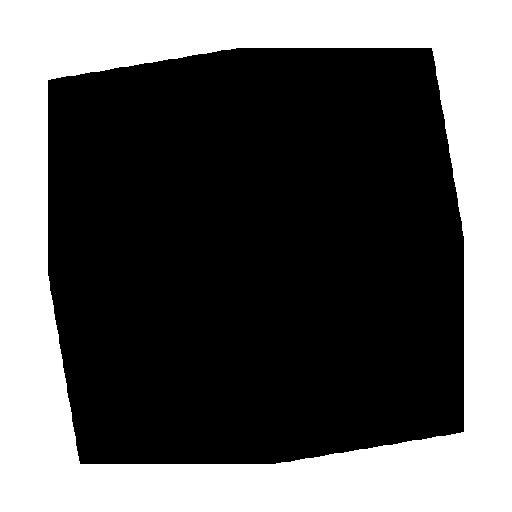

In [41]:
compute_transparency_mask(transformed_image)

In [25]:
def outpaint(pipe_inpaint, image, mask):
    prompt = "a photo of a person, highly detailed, soft natural lighting, photo realism, professional portrait, ultra-detailed, 4k resolution, wallpaper, hd wallpaper"
    negative_prompt = "magzine, frame, tiled, repeated, multiple people, multiple faces, group of people, split frame, multiple panel, split image, watermark, boarder, diptych, triptych"
    image = pipe_inpaint(prompt=prompt, 
                         negative_prompt=negative_prompt,
                         image=image.convert('RGB'), 
                         mask_image=mask.convert('RGB'),
                         num_inference_steps=50).images[0]
    return image

    

In [8]:
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
import numpy as np
np.array(transformed_image).shape

(512, 512, 4)

  0%|          | 0/50 [00:00<?, ?it/s]

Image 0 done


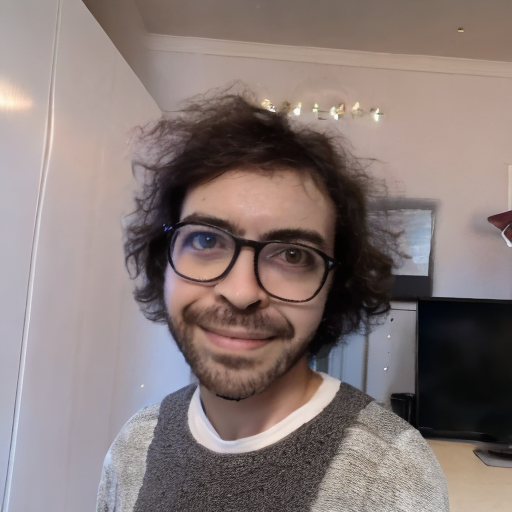

  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 done


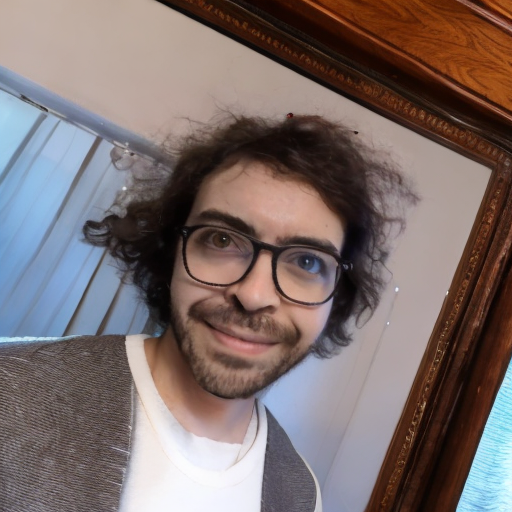

  0%|          | 0/50 [00:00<?, ?it/s]

Image 2 done


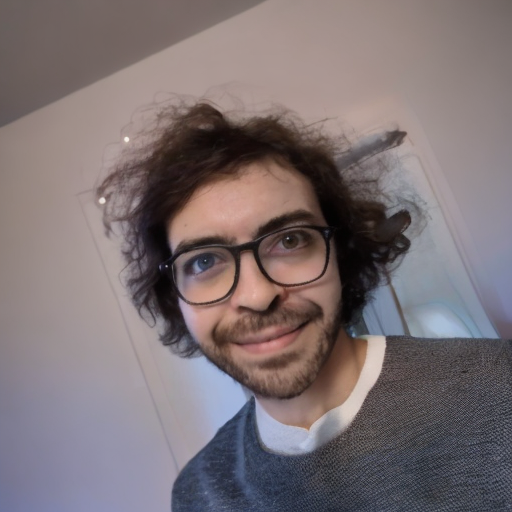

  0%|          | 0/50 [00:00<?, ?it/s]

Image 3 done


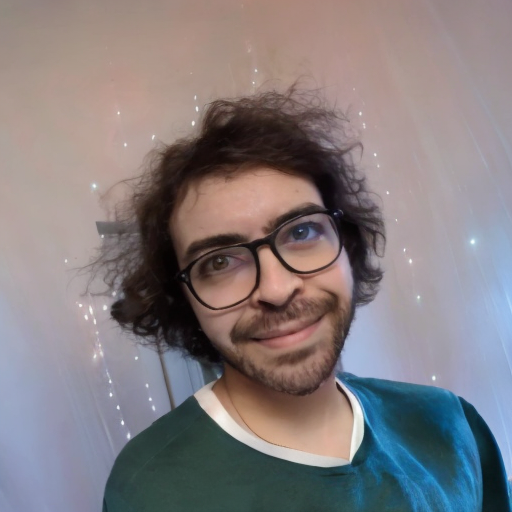

  0%|          | 0/50 [00:00<?, ?it/s]

Image 4 done


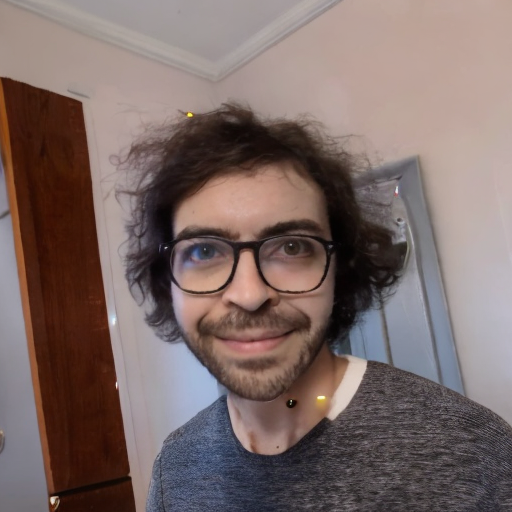

  0%|          | 0/50 [00:00<?, ?it/s]

Image 5 done


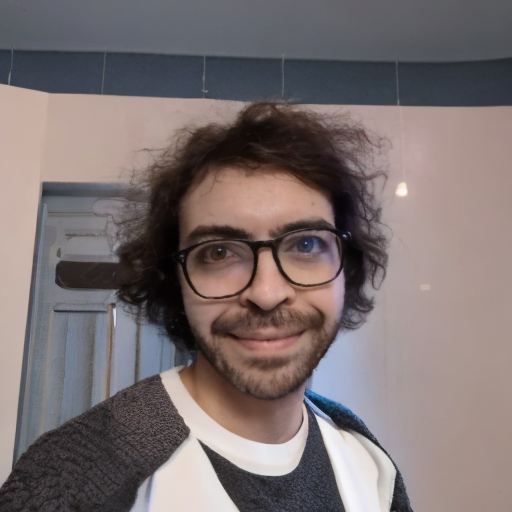

  0%|          | 0/50 [00:00<?, ?it/s]

Image 6 done


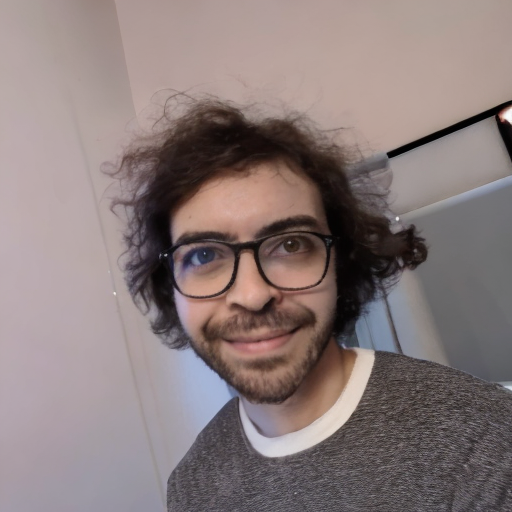

  0%|          | 0/50 [00:00<?, ?it/s]

Image 7 done


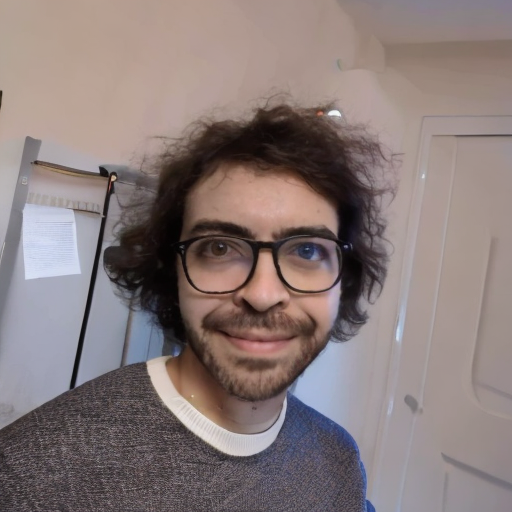

  0%|          | 0/50 [00:00<?, ?it/s]

Image 8 done


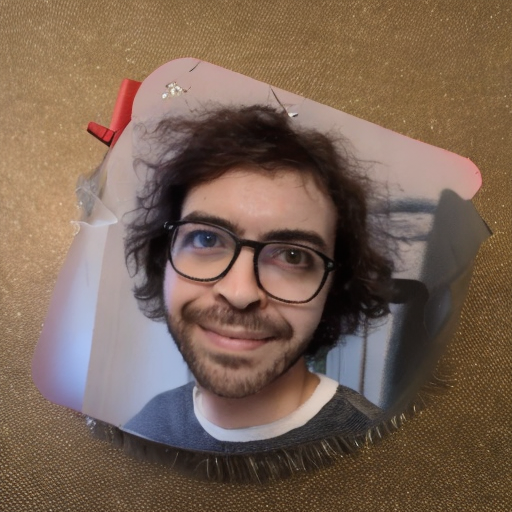

  0%|          | 0/50 [00:00<?, ?it/s]

Image 9 done


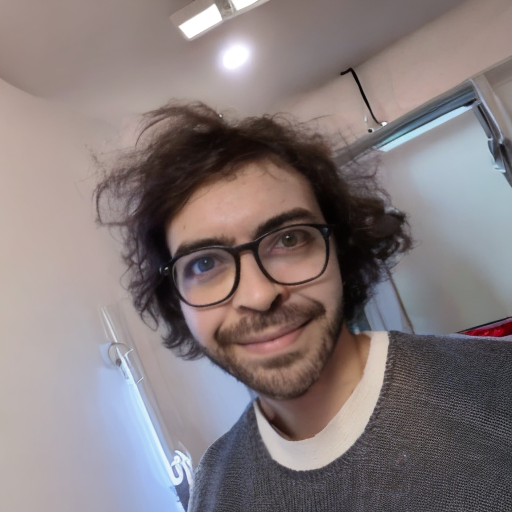

In [47]:
nb_images = 10

save_folder = './training_data/' + ref_image_path.stem + '_augmented'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in range(nb_images):
    transformed_image = train_transform(ref_image)
    mask = compute_transparency_mask(transformed_image)
    outpainted_image = outpaint(pipe_inpaint, transformed_image, mask)
    outpainted_image.save(save_folder + f'/{i}.png')
    print(f'Image {i} done')
    outpainted_image.show()

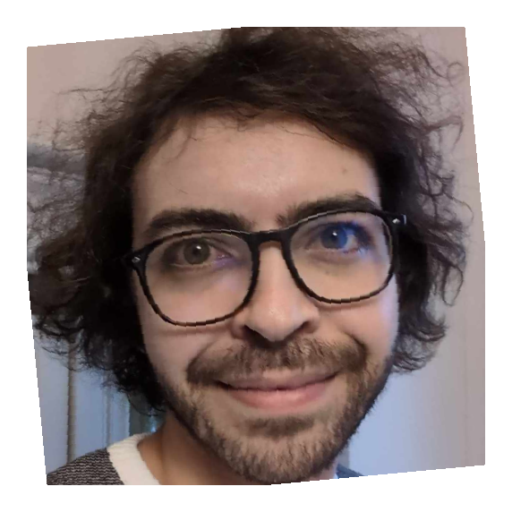

In [7]:
transformed_image

In [12]:

import numpy as np

In [13]:
np.array(transformed_image).shape

(512, 512, 4)

In [16]:
np.array(mask)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [17]:
image =  pipe_inpaint(prompt="a man", 
                         negative_prompt="",
                         image=transformed_image.convert('RGB'), 
                         mask_image=mask,
                         num_inference_steps=50).images[0]

100%|██████████| 50/50 [00:03<00:00, 15.20it/s]
